### Control Lab equipment remotely
* Sun EC13 temperature chamber
* CAEN N6724 digitizer
* CAEN N14171HV supply

In [1]:
# setup
import sys
CRANEPATH = '/opt/cranelab/CraneLab-build/'
CRANEPATH = '/home/achim/gaps/CraneLab/build'
if sys.path[-1] != CRANEPATH:
    sys.path.append(CRANEPATH)

import numpy as np
from skippylab.instruments.powersupplies import CAENN1471HV
from skippylab.instruments.climate_chambers import SunChamber
#import clhvcontrol
import risingsun 
import pyCaenN6725

Can not use adafruit dht sensors on this machine. Try installing requirements with pip3 install Adafruit_DHT


### Operate the high voltage

In [155]:
# currently the hv is connected via USB
# (will change to e0ternet at some point)
HVPORT='/dev/ttyACM0'
#HVPORT='/dev/serial/by-id/usb-CAEN_SPA_NIM_Desktop_HV_Power_Supply-if00'
LOGLEVEL=30
try:
    hv = CAENN1471HV(port=HVPORT,
                                 loglevel=LOGLEVEL,
                                 time_delay=1.0)
except Exception as e:
    print(e)
    print ('Exception caught, try executing the cell again!')


In [146]:
# do something - activate the power

hv.channel0.voltage_as_set = 250
hv.channel0.current_as_set = 100.0 # 10 micro amps
hv.channel0.ramp_up = 3
hv.channel0.ramp_down = 3
hv.channel0.activate()


OSError: [Errno 5] Input/output error

In [156]:
# and deactivate
hv.channel0.ramp_down = 3
hv.channel0.deactivate()

### Operate the SUN EC13 temperature chamber

In [10]:
import time
import numpy as np

import risingsun


SUNPORT = '/dev/ttyUSB1'
SUNPORT='/dev/serial/by-id/usb-Prologix_Prologix_GPIB-USB_Controller_PX30FLUZ-if00-port0'
sunec = SunChamber(risingsun.chamber.PrologixUsbGPIBController(port=SUNPORT),
                                     publish=False,
                                     port=SUNPORT)

SUN EC13 chamber reporting status....
----------------------------------


In [68]:
sunec.get_temperature()

20.017

In [ ]:
# power it on

sunec.OFF

<IPython.core.display.Javascript object>


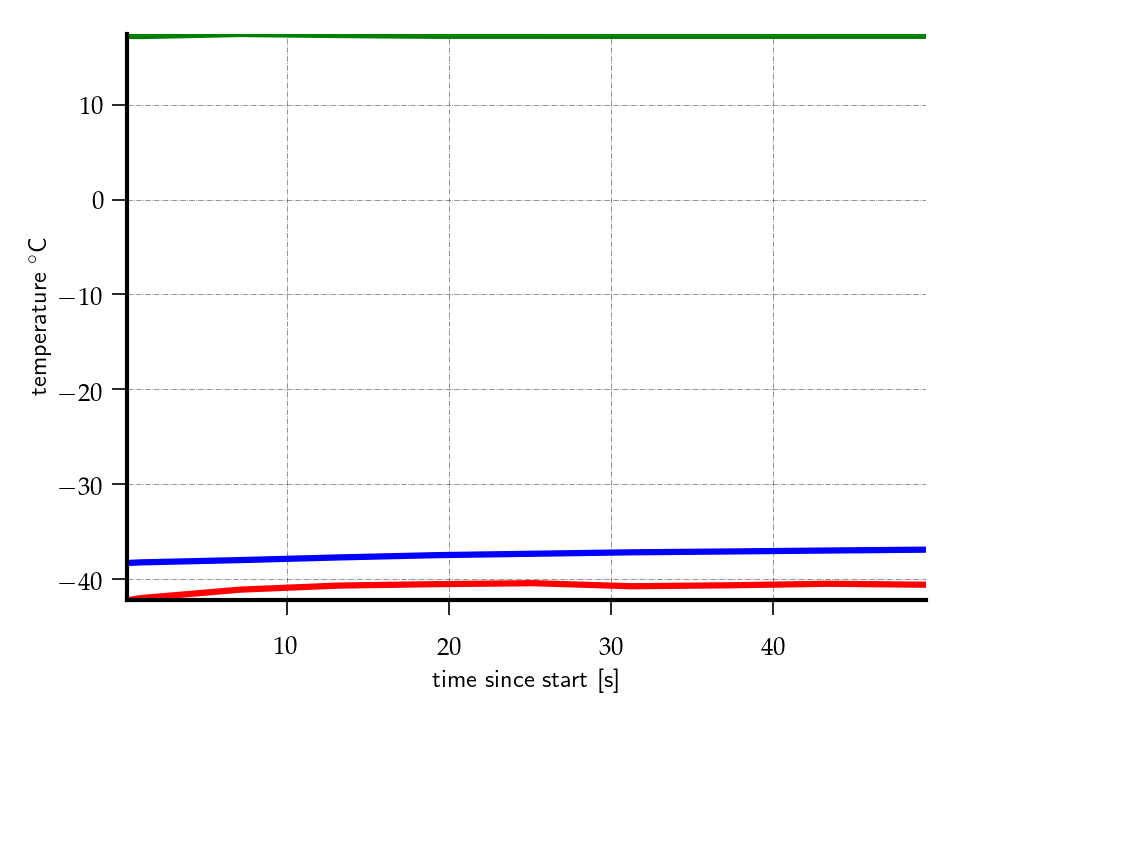

KeyboardInterrupt: 

In [25]:
%matplotlib notebook
# cooldown
sunec.activate_cooler()
sunec.deactivate_heater()

sunec.rate_as_set = 3
sunec.temperature_as_set = -45
sunec.monitor_temperatures()

In [83]:
sunec.open_dry_nitrogen_valve()


<IPython.core.display.Javascript object>


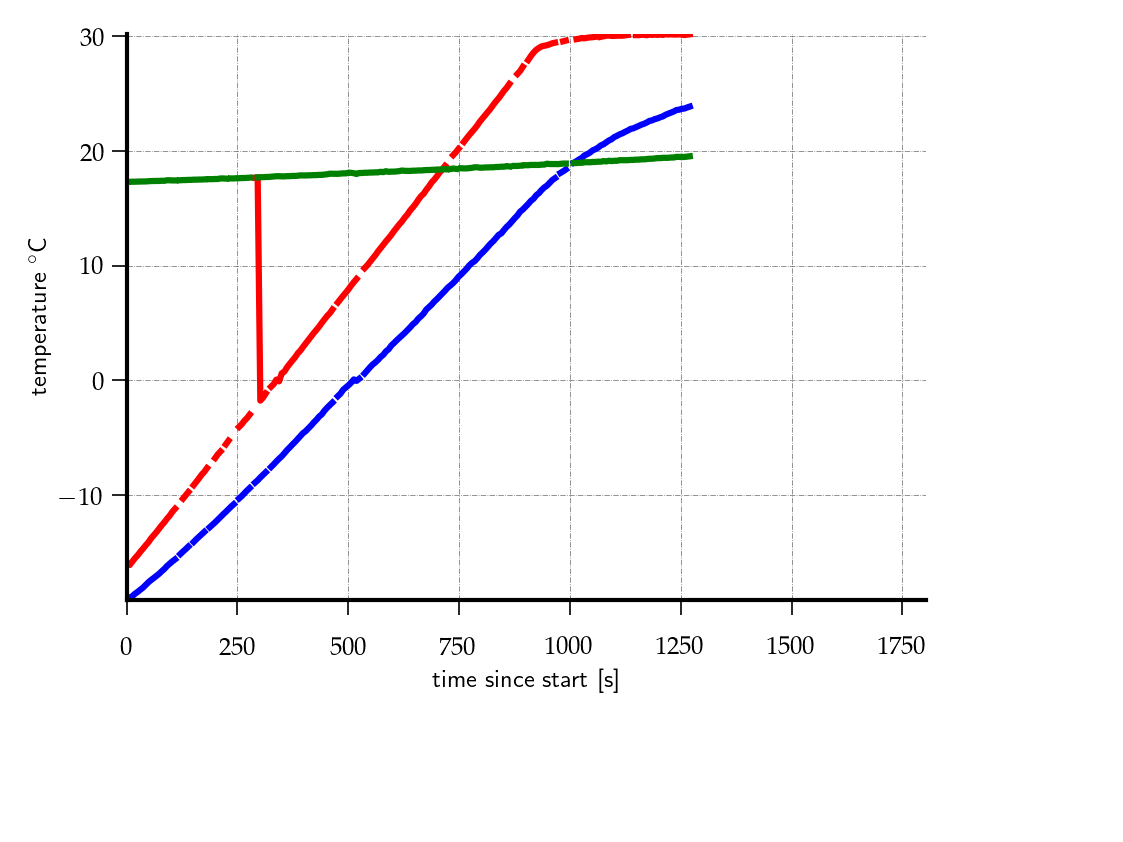

OSError: [Errno 5] Input/output error

In [27]:
%matplotlib notebook

sunec.deactivate_cooler()
sunec.activate_heater()
sunec.temperature_as_set = 30
sunec.open_dry_nitrogen_valve()
sunec.monitor_temperatures()

In [188]:
# warmup
#FIMXE: close the valve
sunec.rate_as_set = 3
sunec.open_dry_nitrogen_valve()
#time.sleep(10)

sunec.deactivate_cooler()
sunec.activate_heater()
sunec.temperature_as_set = 30

<IPython.core.display.Javascript object>


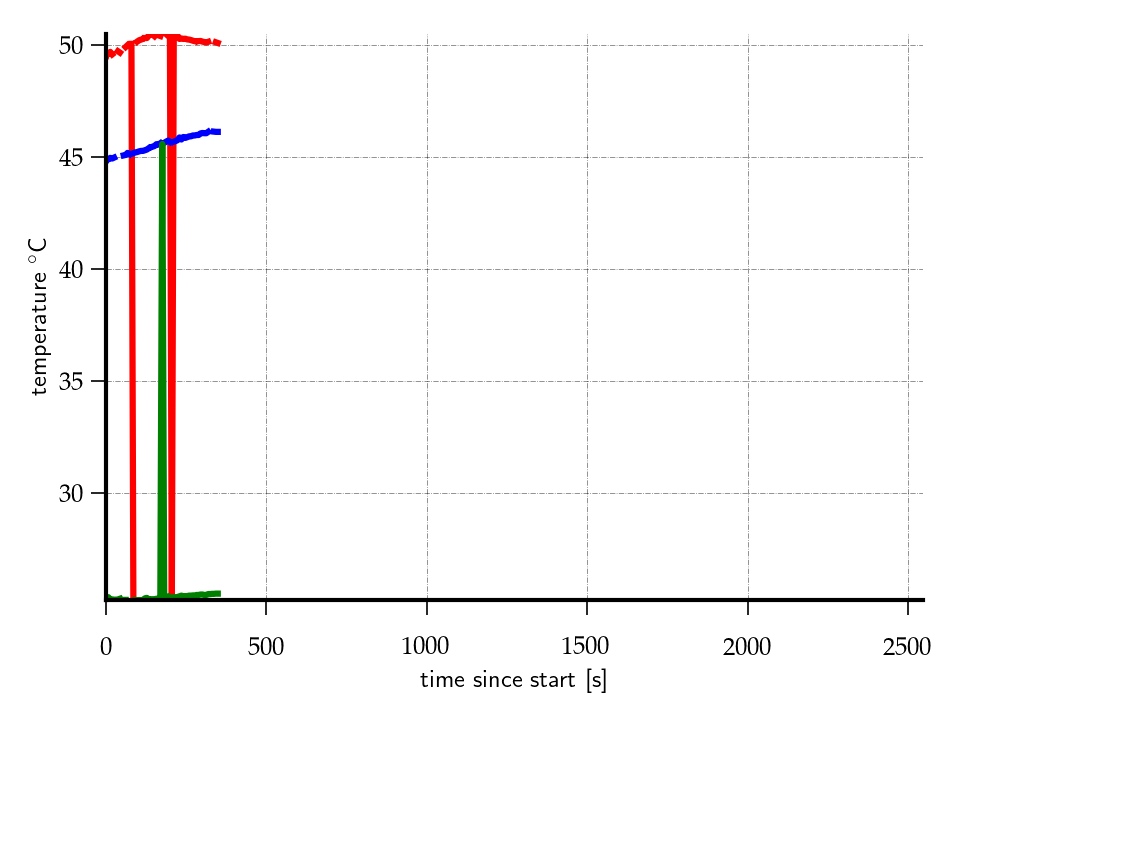

The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')

The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')

The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')

The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')



KeyboardInterrupt: 

In [7]:
# turn it off

sunec.monitor_temperatures()

In [ ]:
sunec.open_dry_nitrogen_valve()

In [ ]:
sunec.close_dry_nitrogen_valve()

In [ ]:
monitor_internal_temperatures()

In [ ]:
%matplotlib notebook
# readout


import pylab as p
try:
    p.style.use('risingsun')
    p.style.use('HErmes-present')
except Exception as e:
    print(e)
    print('Style files not found, no worries...')
    
def monitor_internal_temperatures():
    fig = p.figure(dpi=150)
    ax = fig.gca()
    ax.set_xlabel("time since start [s]")
    ax.set_ylabel("temperature $^{\circ}$C")
    p.ion()
    line_plots = [ax.plot(range(0), color=k, lw=3)[0] for k in ("r", "b")]


    start_time = time.monotonic()

    fig.show()
    fig.canvas.draw()

    while True:
        sec = time.monotonic() - start_time
        datamins, datamaxes = [],[]
        for ch, line_plot in enumerate(line_plots):
        
            temp = sunec.get_temperature(ch)
            secs, temps = line_plot.get_data()
            secs = np.append(secs,sec)
            temps = np.append(temps,temp)
            line_plot.set_ydata(temps)
            line_plot.set_xdata(secs)
            datamins.append(min(temps))
            datamaxes.append(max(temps))
            xmin = min(secs)
            xmax = max(secs)
            
        datamax = max(datamaxes)
        datamin = min(datamins)
        #print(secs)
        if len(secs) == 1:
            continue
    
        # avoid matplotlib warning
        if abs(datamin - datamax) < 1:
            datamin -= 1
            datamax += 1

        if abs(xmax - xmin) < 1:
            xmin -= 1
            xmax += 1

        # update the plot
        ax.set_xlim(xmin=xmin, xmax=xmax)
        ax.set_ylim(ymin=datamin, ymax=datamax)

    
        fig.canvas.draw()
        time.sleep(5)

In [158]:
import skippylab.instruments.oscilloscopes as osc

rs = osc.RhodeSchwarzRTO1044('192.168.1.6')
print(rs.ping())
rs.instrument.ask("*IDN?")

True


'Rohde&Schwarz,RTM3004US,1335.8794k04/102509,01.501'

In [50]:
rs.active_channel

'CHAN1'

In [52]:
rs.ACQUIRE_ONE

'SEQ'

In [55]:
rs.acquire_waveform?

In [57]:
rs.do_single_acquisition?

In [ ]:
rs.acquire_waveform()

In [159]:
origin = rs.instrument.ask('CHANnel1:DATA:XORigin?')
xincre = rs.instrument.ask('CHANnel1:DATA:XINC?')
print (origin)
print (xincre)
alldata = []

-2.999936000E-04
4.600000000E-09


In [160]:
import tqdm
import pickle

for k in range(50):
    #sunec.OFF
    alldata = []
    for i in range(100):
        print(k,i)
        rs.instrument.write("RUNSingle")
        rs.instrument.write('ACQuire:NSINgle:COUNt 1')
        #time.sleep(1)
        while(True):

            finished = rs.instrument.ask('ACQuire:STATe?')
            #print(finished)
            time.sleep(0.2)
            if (finished == "COMP"):
                data = rs.instrument.ask("CHAN1:DATA?")
                #print (data[:12])
                alldata.append(data)
                break
            #if (finished == "STOP"):
           #     print ('stopped')
           #     try:
           #         data = rs.instrument.ask("CHAN1:DATA?")
           #         print (data[:12])
           #         alldata.append(data)
           #         break
           #     except Exception as e:
           #         print (e)
           #         continue

    datatosave = dict()
    datatosave['xorig'] = origin
    datatosave['xincr'] = xincre
    datatosave['volts'] = alldata
    try:
        filetosavepi = open(f'/home/achim/xray{k}.pickle', "xb")
    except:
        filetosavepi = open(f'/home/achim/xrayA{k}.pickle', 'xb')
    pickle.dump(datatosave, filetosavepi)
    filetosavepi.close()
    
    #delta_t = 0
    #start = time.monotonic()
    #sunec.ON
    #temp = sunec.get_temperature()
    #while (not (np.isfinite(temp))):
    #    temp = sunec.get_temperature()
    #while temp > -42:
    #    print (temp)
    #    sunec.ON
    #    sunec.activate_cooler()
    #    sunec.deactivate_heater()

    #    sunec.rate_as_set = 3
    #    sunec.temperature_as_set = -45
    #    time.sleep(20)
    #    temp = sunec.get_temperature()
    #    while (not (np.isfinite(temp))):
    #        temp = sunec.get_temperature()
    #sunec.OFF

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
2 0
2 1
2 2
2 3
2 4


KeyboardInterrupt: 

In [147]:
temp

<bound method SunChamber.get_temperature of <skippylab.instruments.climate_chambers.SunChamber object at 0x7f6b2d749cd0>>

In [103]:
print (len(alldata))
import pickle
import hjson

datatosave = dict()
datatosave['xorig'] = origin
datatosave['xincr'] = xincre
datatosave['volts'] = alldata
filetosavepi = open('/home/achim/firstmuons.pickle', "xb")
filetosavehj = open('/home/achim/firstmuons.json', 'w')
hjson.dump(datatosave, filetosavehj)
pickle.dump(datatosave, filetosavepi)
filetosavepi.close()
filetosavehj.close()

107


In [101]:
file = open()

1.49023E-03,2.36914E-03,2.27148E-03,1.68555E-03,5.13672E-04,-1.69922E-04,9.04297E-04,1.19727E-03,1.97852E-03,2.17383E-03,3.44336E-03,2.56445E-03,2.66211E-03,1.49023E-03,1.29492E-03,1.58789E-03,2.17383E-03,1.97852E-03,1.09961E-03,1.58789E-03,1.00195E-03,8.06641E-04,1.19727E-03,1.78320E-03,2.46680E-03,1.97852E-03,2.07617E-03,1.78320E-03,2.56445E-03,1.68555E-03,2.07617E-03,2.07617E-03,1.58789E-03,1.78320E-03,1.29492E-03,7.08984E-04,1.58789E-03,1.58789E-03,1.19727E-03,1.49023E-03,1.39258E-03,1.29492E-03,1.49023E-03,1.68555E-03,1.29492E-03,1.39258E-03,1.78320E-03,2.46680E-03,3.24805E-03,2.56445E-03,2.17383E-03,1.58789E-03,1.97852E-03,3.18359E-04,9.04297E-04,9.04297E-04,2.36914E-03,1.97852E-03,1.29492E-03,1.19727E-03,1.49023E-03,7.08984E-04,2.20703E-04,-7.22656E-05,1.00195E-03,1.39258E-03,1.09961E-03,1.00195E-03,7.08984E-04,9.04297E-04,1.29492E-03,7.08984E-04,2.27148E-03,2.75977E-03,4.12695E-03,2.27148E-03,2.27148E-03,1.29492E-03,1.39258E-03,8.06641E-04,7.08984E-04,1.58789E-03,2.07617E-03,2.

In [60]:
data = rs.instrument.ask("CHAN1:DATA?")

'1.49023E-03,1.19727E-03,1.68555E-03,1.23047E-04,1.23047E-04,-1.24414E-03,-1.73242E-03,-2.67578E-04,1.19727E-03,2.36914E-03,5.13672E-04,5.13672E-04,-1.63477E-03,-2.41602E-03,-2.22070E-03,-3.19727E-03,-2.31836E-03,-1.83008E-03,-7.22656E-05,2.20703E-04,-1.04883E-03,-3.68555E-03,-2.41602E-03,-3.29492E-03,4.16016E-04,-1.14648E-03,-1.34180E-03,-1.63477E-03,-2.90430E-03,-3.97852E-03,-5.34570E-03,-4.95508E-03,-2.80664E-03,-2.41602E-03,-6.58203E-04,-1.04883E-03,-1.73242E-03,-3.49023E-03,-3.58789E-03,-3.29492E-03,-2.31836E-03,-7.55859E-04,-7.55859E-04,6.11328E-04,-1.24414E-03,-6.58203E-04,-2.61133E-03,-2.61133E-03,-8.53516E-04,-1.04883E-03,8.06641E-04,-7.55859E-04,-1.43945E-03,-2.31836E-03,-2.80664E-03,-2.61133E-03,-1.34180E-03,-3.65234E-04,3.18359E-04,5.13672E-04,7.08984E-04,7.08984E-04,4.16016E-04,-6.58203E-04,-5.60547E-04,-2.67578E-04,7.08984E-04,-3.65234E-04,-8.53516E-04,-5.60547E-04,-1.83008E-03,-1.34180E-03,-2.51367E-03,-1.34180E-03,-2.67578E-04,4.16016E-04,-3.65234E-04,-9.51172E-04,-8.53